In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
import sys
import metpy
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from matplotlib.colors import to_rgba
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import metpy.calc as mpcalc
import pandas as pd
from netCDF4 import Dataset
import os
import glob
from datetime import datetime
import seaborn as sns
import netCDF4
from netCDF4 import Dataset
from metpy.units import units
import dask
import xarray as xr
# from shapely import Polygon
import regionmask
import geopandas as gpd
import dask
import dask.array as da
from scipy.stats import circmean
import datetime
import pytz
from datetime import datetime, timedelta
from itertools import product

# Calculate Himawari diurnal cycles

In [51]:
# read in bathymetry files
ds_full = xr.open_dataset('/home/563/ac9768/Aus_Bathymetry/ETOPO2v2c_f4.GQp62nWv.nc.part',engine="netcdf4")
ds_bath = ds_full.sel(x=slice(140,155),y=slice(-22,-11))

# read in satellite files
def him8_files(directory):
    file_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith("_ch13BT_regridded_2kmres.nc"):  
                file_paths.append(os.path.join(root, file))
    return file_paths
directory = "/home/563/ac9768/himawari_regridded_files"
files = him8_files(directory)

FileNotFoundError: [Errno 2] No such file or directory: '/home/563/ac9768/Aus_Bathymetry/ETOPO2v2c_f4.GQp62nWv.nc.part'

## Climatology

In [ ]:
# first for climatology, barra not included
# function to calculate mean brightness temperature for the entire rodar domain + for bathymetry>0 and <0 requirements
def read_netcdf_him8(file_path):
    with xr.open_mfdataset(file_path,engine="h5netcdf", chunks="auto") as ds:
        # radar site boundaries
        data_towns = ds.ch13BT.sel(lat=slice(-20.768799,-18.065369),lon=slice(145.10834,147.99347))
        data_cairns = ds.ch13BT.sel(lat=slice(-18.165955,-15.463379),lon=slice(144.26343,147.1026))
        data_willis = ds.ch13BT.sel(lat=slice(-17.636353,-14.93396),lon=slice(148.54926,151.37994))
        # select land vs ocean for cairns and townsville
        bathymetry_towns = ds_bath["z"].sel(x=data_towns.lon,y=data_towns.lat,method="nearest")
        bathymetry_cairns = ds_bath["z"].sel(x=data_cairns.lon,y=data_cairns.lat,method="nearest")
        
        bathymetry_towns_land = bathymetry_towns> 0 
        bathymetry_cairns_land = bathymetry_cairns> 0 
        
        bathymetry_towns_ocean = bathymetry_towns<= 0 
        bathymetry_cairns_ocean = bathymetry_cairns<= 0 
        
        land_towns = xr.where(bathymetry_towns_ocean, np.nan, data_towns)
        land_cairns = xr.where(bathymetry_cairns_ocean, np.nan, data_cairns)
        ocean_towns = xr.where(bathymetry_towns_land, np.nan, data_towns)
        ocean_cairns = xr.where(bathymetry_cairns_land, np.nan, data_cairns)
        
        # calculate mean
        mean_towns_land = land_towns.groupby(land_towns.time.dt.hour).mean(dim=["lat","lon","time"])  
        mean_cairns_land = land_cairns.groupby(land_cairns.time.dt.hour).mean(dim=["lat","lon","time"])  
        mean_towns_ocean = ocean_towns.groupby(ocean_towns.time.dt.hour).mean(dim=["lat","lon","time"])  
        mean_cairns_ocean = ocean_cairns.groupby(ocean_cairns.time.dt.hour).mean(dim=["lat","lon","time"])  
        mean_willis = data_willis.groupby(data_willis.time.dt.hour).mean(dim=["lat","lon","time"])  
    return mean_towns_land, mean_cairns_land,mean_towns_ocean,mean_cairns_ocean,mean_willis

In [ ]:
mean_towns_land,mean_cairns_land,mean_towns_ocean,mean_cairns_ocean,mean_willis = read_netcdf_him8(files)

In [ ]:
%%time
# h8_towns_land = mean_towns_land.compute()
# h8_cairns_land = mean_cairns_land.compute()
h8_towns_ocean = mean_towns_ocean.compute()
h8_cairns_ocean = mean_cairns_ocean.compute()
# h8_willis = mean_willis.compute()

In [ ]:
# change to aest
# h8towns_land = np.roll(h8_towns_land,shift=10)
# h8cairns_land = np.roll(h8_cairns_land,shift=10)
h8towns_ocean = np.roll(h8_towns_ocean,shift=10)
h8cairns_ocean = np.roll(h8_cairns_ocean,shift=10)
# h8willis_ocean = np.roll(h8_willis,shift=10)

NameError: name 'h8_towns_ocean' is not defined

In [ ]:
# save arrays
# np.save('/home/563/ac9768/himawari_regridded_files/h8_clim_willis_ocean.npy', h8willis_ocean)

## Regimes

In [ ]:
def netcdf_him8(file_path,barra_site,wdir1,wdir2,ne=None):
    with xr.open_mfdataset(file_path,engine="h5netcdf", chunks="auto") as ds:
        ds_barra = barra_site.sortby('time') 
        ds_selected = ds_barra.sel(time=slice('2016-01-01', '2020-04-01'))
        barra = ds_selected.sel(time=~(ds_selected['time.month'] == 4))
        winds = barra.wind_dir.compute()
        if ne==True:
            wind_dir = winds[(winds>=wdir1)&(winds<=wdir2)]
        else:
            wind_dir = winds[(winds>wdir1)&(winds<=wdir2)]
        wind_dir.drop_duplicates(dim="time")
        wind_times = wind_dir.time.values
        towns=ds.ch13BT.sel(time=wind_times,method="nearest").sel(lat=slice(-20.768799,-18.065369),lon=slice(145.10834,147.99347))
        cairns=ds.ch13BT.sel(time=wind_times,method="nearest").sel(lat=slice(-18.165955,-15.463379),lon=slice(144.26343,147.1026))
        willis = ds.ch13BT.sel(time=wind_times,method="nearest").sel(lat=slice(-17.636353,-14.93396),lon=slice(148.54926,151.37994))
    return willis 

In [ ]:
barra_towns = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_850hPa_winds_townsville.nc", engine="h5netcdf",chunks="auto")
barra_cairns = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_850hPa_winds_cairns.nc", engine="h5netcdf",chunks="auto")
barra_willis = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_850hPa_winds_willis_island.nc", engine="h5netcdf",chunks="auto")
df = netcdf_him8(files,barra_willis,270,360,ne=False)
# np.sum(np.isnan(df_land.isel(time=0).values))


In [ ]:
df.drop_duplicates(dim="time")

<xarray.DataArray 'ch13BT' (time: 1548, lat: 150, lon: 157)> Size: 146MB
dask.array<getitem, shape=(1548, 150, 157), dtype=float32, chunksize=(149, 150, 157), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 12kB 2016-01-01T12:00:00 ... 2020-03-12T22...
  * lat      (lat) float64 1kB -17.63 -17.61 -17.59 ... -14.98 -14.96 -14.94
  * lon      (lon) float64 1kB 148.6 148.6 148.6 148.6 ... 151.3 151.4 151.4
Attributes:
    regrid_method:  bilinear

In [ ]:
# read in barra files for wind regimes
barra_towns = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_850hPa_winds_townsville.nc", engine="h5netcdf",chunks="auto")
barra_cairns = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_850hPa_winds_cairns.nc", engine="h5netcdf",chunks="auto")
barra_willis = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_850hPa_winds_willis_island.nc", engine="h5netcdf",chunks="auto")
def read_netcdf_him8(file_path,barra_site,wdir1,wdir2,ne=None,towns=None,cairns=None):
    with xr.open_mfdataset(file_path,engine="h5netcdf", chunks="auto") as ds:
        # barra conditions
        ds_barra = barra_site.sortby('time') 
        ds_selected = ds_barra.sel(time=slice('2016-01-01', '2020-04-01'))
        barra = ds_selected.sel(time=~(ds_selected['time.month'] == 4))
        winds = barra.wind_dir.compute()
        if ne==True:
            wind_dir = winds[(winds>=wdir1)&(winds<=wdir2)]
        else:
            wind_dir = winds[(winds>wdir1)&(winds<=wdir2)]
        wind_times = wind_dir.time.values

        if towns==True:
            data_towns = ds.ch13BT.sel(time=wind_times,method="nearest").sel(lat=slice(-20.768799,-18.065369),lon=slice(145.10834,147.99347))
            bathymetry_towns = ds_bath["z"].sel(x=data_towns.lon,y=data_towns.lat,method="nearest")
            bathymetry_towns_land = bathymetry_towns> 0 
            bathymetry_towns_ocean = bathymetry_towns<= 0 
            land_towns = xr.where(bathymetry_towns_ocean, np.nan, data_towns)
            ocean_towns = xr.where(bathymetry_towns_land, np.nan, data_towns)
            mean_land = land_towns.groupby(land_towns.time.dt.hour).mean(dim=["lat","lon","time"])  
            mean_ocean = ocean_towns.groupby(ocean_towns.time.dt.hour).mean(dim=["lat","lon","time"])  
        elif cairns==True:
            data_cairns = ds.ch13BT.sel(time=wind_times,method="nearest").sel(lat=slice(-18.165955,-15.463379),lon=slice(144.26343,147.1026))
            bathymetry_cairns = ds_bath["z"].sel(x=data_cairns.lon,y=data_cairns.lat,method="nearest")
            bathymetry_cairns_land = bathymetry_cairns> 0 
            bathymetry_cairns_ocean = bathymetry_cairns<= 0 
            land_cairns = xr.where(bathymetry_cairns_ocean, np.nan, data_cairns)
            ocean_cairns = xr.where(bathymetry_cairns_land, np.nan, data_cairns)
            mean_land = land_cairns.groupby(land_cairns.time.dt.hour).mean(dim=["lat","lon","time"])  
            mean_ocean = ocean_cairns.groupby(ocean_cairns.time.dt.hour).mean(dim=["lat","lon","time"])  
        else:
            data_willis = ds.ch13BT.sel(time=wind_times,method="nearest").sel(lat=slice(-17.636353,-14.93396),lon=slice(148.54926,151.37994))
            mean_land = 1
            mean_ocean = data_willis.groupby(data_willis.time.dt.hour).mean(dim=["lat","lon","time"])  
    return mean_land,mean_ocean

In [ ]:
mean_land,mean_ocean = read_netcdf_him8(files,barra_towns,0,90,ne=True,towns=True,cairns=False)

In [ ]:
mean_landC,mean_oceanC = read_netcdf_him8(files,barra_cairns,0,90,ne=True,towns=False,cairns=True)

In [ ]:
na,mean_W = read_netcdf_him8(files,barra_willis,0,90,ne=True,towns=False,cairns=False)

In [ ]:
h8_oceanT = mean_ocean.compute()
h8_oceanC = mean_oceanC.compute()

In [ ]:
# change to aest
h8T = np.roll(h8_oceanT,shift=10)
h8C = np.roll(h8_oceanC,shift=10)

In [ ]:
# save arrays
np.save('/home/563/ac9768/himawari_regridded_files/h8_ne_cairns_ocean-v2.npy', h8C)
np.save('/home/563/ac9768/himawari_regridded_files/h8_ne_towns_ocean-v2.npy', h8T)

# Open radar dataset

In [15]:
def path_to_radar_ds(radar_site_no):
    """
    List of yyyymm (year+month) with available radar data.
    For each yyyymm create a list of entire file paths to netCDF4 files.

    Parameters:
    - radar_site_no (str): Radar site number- BoM ID's for radar locations: Townsville=73, Cairns=19, and Willis Island=41 

    Returns:
    - list: list object of netCDF4 files
    """
    list = ["202201","202202","202203","202204","202101","202102","202103","202104","202001","202002","202003","202004","201901","201902","201903","201904",
           "201801","201802","201803","201804","201701","201702","201703","201704","201601","201602","201603","201604","201501","201502",
           "201503","201504","201401","201402","201403","201404","201301","201302","201303","201304","201201","201202","201203","201204",
          ] 
    # list = ["202001","202002","202003","201901","201902","201903","201801","201802","201803","201701","201702","201703","201601","201602","201603","201501","201502","201503",
    #       ] 
    files_list = []
    for i in list:
        fp = "/g/data/rq0/admin/level_2_decomissioned_fields/"+radar_site_no+"/RAINRATE/"
        all_files = [os.path.join(root, f) for root, _, files in os.walk(fp)
            for f in files
            if f.startswith(radar_site_no+'_'+i) and f.endswith('.nc')]
        files_list.extend(all_files)
    files_list.sort()
    return files_list

# towns_radar_files = path_to_radar_ds("73")
# cairns_radar_files = path_to_radar_ds("19")
willis_radar_files = path_to_radar_ds("41")

In [4]:
def create_radar_mask(file_path, threshold,chunks={'time': 'auto', 'x': 'auto', 'y': 'auto'},land=None,ocean=None):
    ds_full = xr.open_dataset('/home/563/ac9768/GBR/Aus_Bathymetry/ETOPO2v2c_f4.GQp62nWv.nc.part',engine="netcdf4")
    ds_bath = ds_full.sel(x=slice(140,155),y=slice(-22,-11))
    print("bathymetry")
    with xr.open_mfdataset(file_path, engine="netcdf4",combine='by_coords', chunks=chunks, parallel=True) as ds:
        ds_mean = ds.rainrate.mean(dim='time')
        condition1 = ~ds.rainrate.mean(dim='time').isnull()
        print(condition1.compute().sum())
        print("calculated mean rr")
        file = xr.open_dataset(file_path[0], engine="netcdf4") 
        bathymetry = ds_bath["z"].sel(x=file.longitude,y=file.latitude,method="nearest")
        masked_beam_blockage = xr.where((ds_mean < threshold), np.zeros_like(ds_mean),np.ones_like(ds_mean)) ##each hour then has its own mask
        if land==True:
            bath = xr.where((bathymetry <= 0), np.zeros_like(bathymetry),np.ones_like(bathymetry))
            condition2 = bath.astype(bool)
            condition3 = masked_beam_blockage.astype(bool)
            mask = condition1 & condition2 & condition3
        elif ocean==True:
            bath = xr.where((bathymetry > 0), np.zeros_like(bathymetry),np.ones_like(bathymetry))
            condition2 = bath.astype(bool)
            condition3 = masked_beam_blockage.astype(bool)
            mask = condition1 & condition2 & condition3
        else:
            mask = ~ds.rainrate.mean(dim='time').isnull()
    return mask 

# Calculate rain rate intensity diurnal cycle

In [3]:
def process_hour_int(ds):
    """
    Sum the number of non raining points (value = 0) across x, y and time ignoring Nans. Sum the
    number of raining points. Compute those values. Calculate the total of valid data points (raining + non-raining). Calculate the frequency
    where the number of raining points is divided by the total valid points * 100.
    
    Parameters:
    - ds (str): Path to the netCDF file(s).
    
    Returns:
    - int: Intensity of raining points (mm/h)
    """
    
    intensity = ds.mean(dim=["time",'x','y'],skipna=True) 
    return intensity

In [6]:
%%time
cairns_land = create_radar_mask(cairns_radar_files, 1.2,land=True,ocean=False)

bathymetry
<xarray.DataArray 'rainrate' ()> Size: 8B
array(68365)
calculated mean rr
CPU times: user 27min 36s, sys: 4min 32s, total: 32min 8s
Wall time: 20min 41s


In [5]:
%%time
cairns_ocean = create_radar_mask(cairns_radar_files, 1.2,land=False,ocean=True)

bathymetry
<xarray.DataArray 'rainrate' ()> Size: 8B
array(68365)
calculated mean rr
CPU times: user 30min 9s, sys: 4min 33s, total: 34min 43s
Wall time: 23min 12s


<xarray.DataArray 'rainrate' ()> Size: 8B
array(68365)
calculated mean rr
CPU times: user 30min 9s, sys: 6min 9s, total: 36min 18s
Wall time: 24min 7s


In [17]:
willis_mask = create_radar_mask(willis_radar_files, 1.2,land=False,ocean=False)

bathymetry
<xarray.DataArray 'rainrate' ()> Size: 8B
array(65836)
calculated mean rr


In [7]:
%%time
towns_land = create_radar_mask(towns_radar_files, 0.8,land=True,ocean=False)

bathymetry
<xarray.DataArray 'rainrate' ()> Size: 8B
array(70616)
calculated mean rr
CPU times: user 23min 18s, sys: 3min 38s, total: 26min 56s
Wall time: 17min 59s


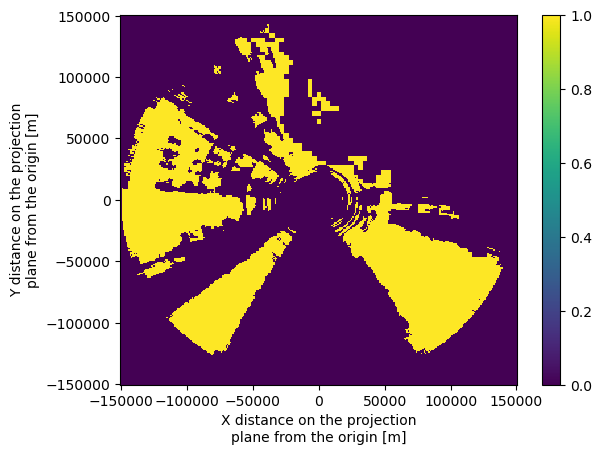

In [7]:
towns_land.plot()

In [9]:
towns_ocean = create_radar_mask(towns_radar_files, 0.8,land=False,ocean=True)

bathymetry
<xarray.DataArray 'rainrate' ()> Size: 8B
array(70616)
calculated mean rr


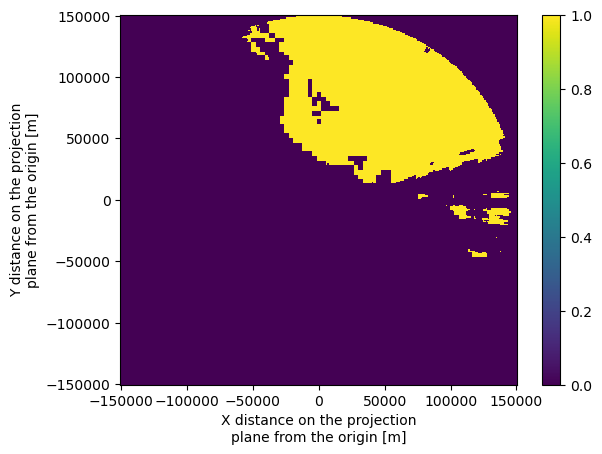

In [9]:
towns_ocean.plot()

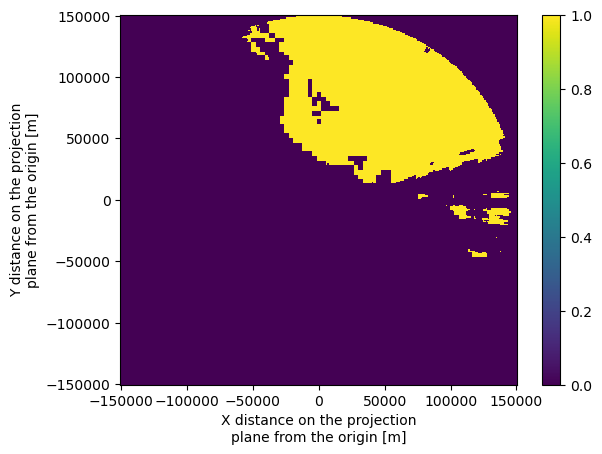

In [10]:
towns_ocean.plot()

In [18]:
def open_radar(file_path):
    with xr.open_mfdataset(file_path, engine="h5netcdf", chunks="auto") as ds:            
        nan_to_zero = ds.rainrate.fillna(0) # creates a much lower mean threshold (if used for masking) - includes non raining periods           
        return ds,nan_to_zero
    
# entire_radar_dsC,nan_filled_dsC = open_radar(cairns_radar_files)
# entire_radar_ds,nan_filled_ds = open_radar(towns_radar_files)
entire_radar_dsW,nan_filled_dsW = open_radar(willis_radar_files)

# apply the masks created above
# masked_ds_land = nan_filled_dsC.where(cairns_land)
# masked_ds_ocean = nan_filled_dsC.where(cairns_ocean)
# masked_ds_landT = nan_filled_ds.where(towns_land)
# masked_ds_oceanT = nan_filled_ds.where(towns_ocean)
mask_willis = nan_filled_dsW.where(willis_mask)

In [19]:
def radar_variable_isfile_mask(entire_radar_dataset,masked_radar_ds):
    qc = entire_radar_dataset.isfile.compute()[entire_radar_dataset.isfile.compute()>0] # when greater than 0: valid time-step
    final_mask = masked_radar_ds.where(qc)
    return final_mask
# masked_land_dsC = radar_variable_isfile_mask(entire_radar_dsC,masked_ds_land)
# masked_ocean_dsC = radar_variable_isfile_mask(entire_radar_dsC,masked_ds_ocean)
# masked_land_dsT = radar_variable_isfile_mask(entire_radar_ds,masked_ds_landT)
# masked_ocean_dsT = radar_variable_isfile_mask(entire_radar_ds,masked_ds_oceanT)
masked_willis = radar_variable_isfile_mask(entire_radar_dsW,mask_willis)

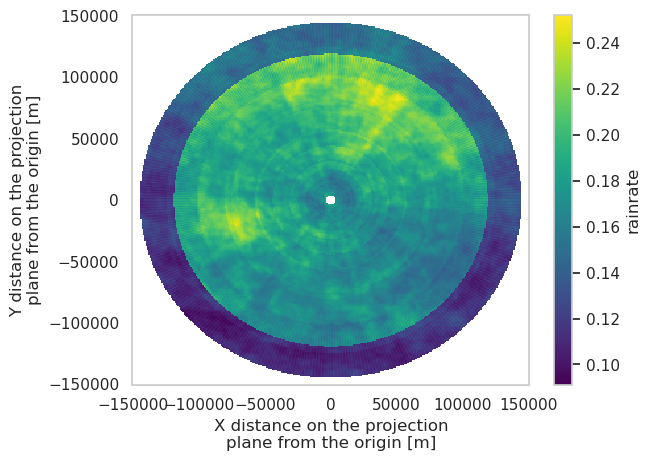

In [45]:
mask_willis.mean('time').plot()

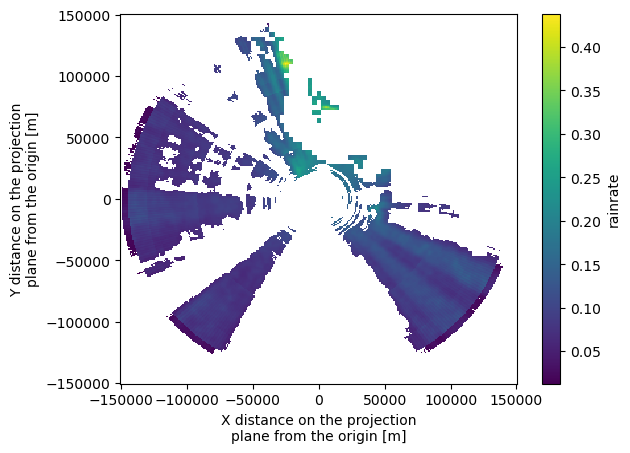

In [13]:
masked_ds_land.mean(['time']).plot()

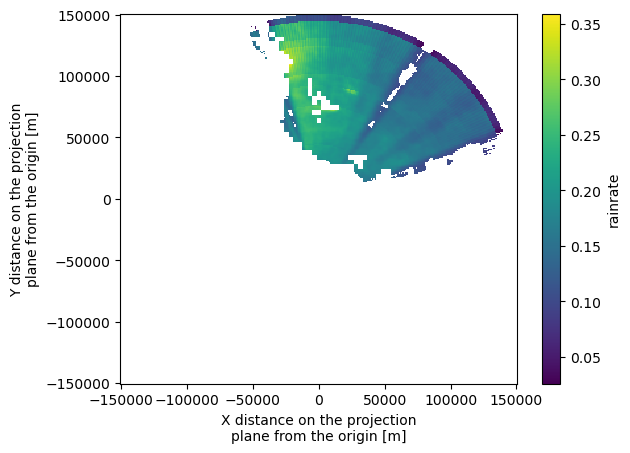

In [10]:
masked_ds_ocean.mean(['time']).plot()

In [ ]:
def generate_diurnal_ds(ds,wind_dir,wind_dir1,wind_dir2,ne=None):
    # select wind directions
    winds = wind_dir.wind_dir.compute()
    if ne==True:
        wind = winds[(winds>=wind_dir1)&(winds<=wind_dir2)]
    else:
        wind = winds[(winds>wind_dir1)&(winds<=wind_dir2)]

    # select wind time values
    wind = wind.drop_duplicates(dim="time")
    wind_times = wind.time.values
    wind_times.sort() 
    print(len(wind_times))

    # Define the time window of 30 minutes - to select radar data +30/-30min of selected BARRA2 wind direction hour
    window_size = pd.Timedelta(minutes=30)
    
    # Initialize empty list to store selected data
    selected_data = []
    # Loop through each time point in wind (directions chosen above); or for deep easterlies, through: wind_speed_SE_10ms
    for time in wind_times:
        # Calculate the start and end times of the window
        window_start = time - window_size
        window_end = time + window_size
        # Select the data within the time window from ds2 using slice
        data_within_window = ds.sel(time=slice(window_start, window_end))
        # Append the selected data to the list
        selected_data.append(data_within_window)
        
    # Concatenate the selected data into a single xarray dataset
    radar_composite_winds = xr.concat(selected_data, dim='time').drop_duplicates(dim="time")
    print(len(radar_composite_winds.time))
    intensity = radar_composite_winds.groupby(radar_composite_winds.time.dt.hour).apply(process_hour_int)
    return intensity

In [9]:
def save_as_zarray(file_path,ds):
    save_file_path = file_path
    ds.to_zarr(save_file_path)
    return

In [10]:
# open barra 850 hPa wind datasets
barra_towns = xr.open_dataset("/home/563/ac9768/GBR/barra-2/barra-2_850hPa_winds_townsville.nc", engine="h5netcdf",chunks="auto")
barra_cairns = xr.open_dataset("/home/563/ac9768/GBR/barra-2/barra-2_850hPa_winds_cairns.nc", engine="h5netcdf",chunks="auto")
barra_willis = xr.open_dataset("/home/563/ac9768/GBR/barra-2/barra-2_850hPa_winds_willis_island.nc", engine="h5netcdf",chunks="auto")

In [24]:
%%time
# ne = generate_diurnal_ds(masked_willis,barra_willis,0,90,ne=True) 
# se = generate_diurnal_ds(masked_willis,barra_willis,90,180,ne=False)
# sw = generate_diurnal_ds(masked_willis,barra_willis,180,270,ne=False)
# nw = generate_diurnal_ds(masked_willis,barra_willis,270,360,ne=False)
clim = generate_diurnal_ds(masked_ocean_dsC,barra_cairns,0,360,ne=True)

file_save_name = 'rr_intensity_willis_ocean_clim'
save_as_zarray("/home/563/ac9768/GBR/radar/"+file_save_name+".zarr",clim)

30288
257872
CPU times: user 28min 26s, sys: 4min 57s, total: 33min 24s
Wall time: 19min 5s


# Calculate rain rate frequency diurnal cycle

In [8]:
def process_hour_freq(ds):
    """
    Sum the number of non raining points (value = 0) across x, y and time ignoring Nans. Sum the
    number of raining points. Compute those values. Calculate the total of valid data points (raining + non-raining). Calculate the frequency
    where the number of raining points is divided by the total valid points * 100.
    
    Parameters:
    - ds (str): Path to the netCDF file(s).
    
    Returns:
    - int: Frequency of raining points (%)
    """
    number_of_nonraining_points = (ds == 0).where(~ds.isnull()).sum(dim=['x', 'y', 'time'])
    number_of_raining_points = (ds != 0).where(~ds.isnull()).sum(dim=['x', 'y', 'time'])
    total_count = (number_of_nonraining_points) + (number_of_raining_points)
    freq = (number_of_raining_points / total_count) * 100
    return freq

In [15]:
def calc_rr(file_path,barra_site,wdir1,wdir2,mask,chunks={'time': 'auto', 'x': 'auto', 'y': 'auto'},regime=None,ne=None):
    """
    If winds are from the NE make condition where NE wind regimes is true 0degrees is =>.
    Fill Nan with zeros (so that non raining points are filled as zero). Apply the (land/ocean/willis CAPPI grid) masks to only look at valid time
    steps, mask using the isfile variable. 
    Group ds by hour, and apply the process_hour_freq function. Return frequencies (%) or intensity.
    
    Parameters:
    - file_path (str): Path to the netCDF file(s).
    - barra_site (ds): BARRA-2 850hPa wind regime dataset (Townsville, Cairns or Willis Island)
    - wdir1 (int): Wind direction (degrees) beginning of range
    - wdir2 (int): Wind direction (degrees) end of range
    
    Returns:
    - array: data array of frequencies for each hour of the day.
    """
    with xr.open_mfdataset(file_path, engine="netcdf4",combine='by_coords', chunks=chunks, parallel=True) as ds:
        ds_mean = ds.rainrate.mean(dim='time')
        print('calculated ds_mean')
        # open bathymetry dataset to apply land-sea masks
        ds_full = xr.open_dataset('/home/563/ac9768/Aus_Bathymetry/ETOPO2v2c_f4.GQp62nWv.nc.part',engine="netcdf4")
        ds_bath = ds_full.sel(x=slice(140,155),y=slice(-22,-11))

        # Make a condition where if regimes are true, select specific times from dataset
        if regime==True:
            ds_barra = barra_site.sortby("time")
            winds = ds_barra.wind_dir.compute()
            if ne==True:
                wind_dir = winds[(winds>=wdir1)&(winds<=wdir2)]
            else:
                wind_dir = winds[(winds>wdir1)&(winds<=wdir2)]
            wind_regime = wind_dir.time.values
            # make a window to use rr data 30min before and after the hour
            window_size = pd.Timedelta(minutes=30)
            selected_data = []
                # # Loop through each time point in wind regime
            for time in wind_regime: 
                # Calculate the start and end times of the window
                window_start = time - window_size
                window_end = time + window_size
                # Select the data within the time window from ds2 using slice
                # data_within_window = ds.rainrate.sel(time=slice(window_start, window_end))
                data_within_window = ds.sel(time=slice(window_start, window_end))
                # Append the selected data to the list
                selected_data.append(data_within_window)
            select_regime = xr.concat(selected_data, dim='time')
            apply_mask = select_regime.rainrate.where(mask)
            nan_to_zero = apply_mask.rainrate.fillna(0)
            # create a mask which looks if the isfile variable>0 at selected times
            maskisfile = select_regime.isfile[select_regime.isfile.values>0]
            # mask invalid time and spatial points (non-raining points kept as zeros)
            valid_data_points = nan_to_zero.where(maskisfile)
        else:
            selected_data = []
            window_size = pd.Timedelta(minutes=30)
            # Loop through each time point in wind regime
            for time in ds.time.values: 
                # Calculate the start and end times of the window
                window_start = time - window_size
                window_end = time + window_size
                # Select the data within the time window from ds2 using slice
                # data_within_window = ds.rainrate.sel(time=slice(window_start, window_end))
                data_within_window = ds.sel(time=slice(window_start, window_end))
                # Append the selected data to the list
                selected_data.append(data_within_window)
            select_regime = xr.concat(selected_data, dim='time')
            ### apply mask
            apply_mask = select_regime.rainrate.where(mask) #boolean mask, xr.where(cairns_land>=0,rr.rainrate,np.nan) = non-boolean mask
            nan_to_zero = apply_mask.rainrate.fillna(0)
            maskisfile = ds.isfile[ds.isfile.values>0]
            valid_data_points = nan_to_zero.where(maskisfile)
            # apply process_hour_freq function to groupby hour object 
        print('apply functions')
        # intensity = valid_data.groupby(valid_data.time.dt.hour).apply(process_hour_int)
        frequencies = valid_data.groupby(valid_data.time.dt.hour).apply(process_hour_freq)
    return frequencies#,intensity

In [ ]:
%%time
barra_towns = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_850hPa_winds_townsville.nc", engine="h5netcdf",chunks="auto")
barra_cairns = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_850hPa_winds_cairns.nc", engine="h5netcdf",chunks="auto")
barra_willis = xr.open_dataset("/home/563/ac9768/barra-2/barra-2_850hPa_winds_willis_island.nc", engine="h5netcdf",chunks="auto")

# towns_rri = calc_rr(towns_radar_files,barra_towns,270,360,towns_land,chunks={'time': 'auto', 'x': 'auto', 'y': 'auto'},regime=False,ne=False)
cairns_rrf = calc_rr(cairns_radar_files,barra_cairns,270,360,cairns_land_test,chunks={'time': 'auto', 'x': 'auto', 'y': 'auto'},regime=False,ne=False)

calculated ds_mean


# Plotting function

In [2]:
# get data & create dictionary for plotting
base_path = '/home/563/ac9768/GBR/radar'
bt_path = '/home/563/ac9768/GBR/himawari_regridded_files'
regimes = ['ne', 'se', 'sw', 'nw'] #clim
sites = ['towns-land', 'cairns-land', 'towns-ocean', 'cairns-ocean', 'willis']
parameters = ['bt','rrf','rri']
# Dictionary to store all data
data = {}

for regime in regimes:
    data[regime] = {}
    for site in sites:
        data[regime][site] = {}
        for parameter in parameters:
            if parameter == 'rrf':
                suffix = f'{regime}_{site}_{parameter}.npy' 
                path = os.path.join(base_path, suffix)  
                data[regime][site][parameter] = np.roll(np.load(path),shift=1)
            elif parameter == 'rri':
                suffix = f'{regime}_{site}_{parameter}.zarr' 
                path = os.path.join(base_path, suffix+'/rainrate') 
                if os.path.exists(path):
                    data[regime][site][parameter] = np.roll(da.from_zarr(path).compute(),shift=11)
                else:
                    print(f"Missing file: {path}, skipping.")
            else:
                suffix = f'{regime}_{site}_{parameter}.npy' 
                path = os.path.join(bt_path, suffix)  
                data[regime][site][parameter] = np.roll(np.load(path),shift=1)


In [17]:
def diurnal_cycle_plot(bt_min, bt_max, f_max, rr_max, data):
    fig, ax = plt.subplots(5, 3, figsize=[10, 10])
    fig.tight_layout()
    sns.set_theme(style="ticks")

    parameters = ['bt', 'rrf', 'rri']
    titles = ['Cloud BT', 'RR Frequency', 'RR Intensity']
    locations = ['towns-land', 'cairns-land', 'towns-ocean', 'cairns-ocean', 'willis']
    ylabels = ['Townsville\nLand', 'Cairns\nLand', 'Townsville\nOcean', 'Cairns\nOcean', 'Willis\nIsland']
    regime_labels = ['NE', 'SE', 'SW', 'NW']
    regimes = list(data.keys())
    colors = ['green', 'royalblue', 'purple', 'orange']

    # Set column titles
    for i, param in enumerate(titles):
        ax[0, i].set_title(param, fontsize=20, pad=15)

    # Set y-axis labels and x-axis labels
    for i, loc in enumerate(ylabels):
        for j in range(3):
            letter = chr(97 + i*3 + j)
            ax[i, j].set_title(f"({letter})", loc="left", fontsize=15)
            
            ax[i, j].set_xlim(0, 23)
            ax[i,j].set_xticks(np.arange(0,24,6))
            if i == 4:
                ax[i, j].set_xlabel('Hour (LT)', fontsize=15)
        ax[i, 0].set_ylim(bt_min, bt_max)
        ax[i, 0].invert_yaxis()
        ax[i, 1].set_ylim(0, f_max)
        ax[i, 2].set_ylim(0, rr_max)
        ax[i, 0].set_ylabel('K',fontsize='15')
        ax[i, 1].set_ylabel('%',fontsize='15')
        ax[i, 2].set_ylabel('mm h$^{-1}$',fontsize='15')
        # Second label above the y-axis
        ax[i, 0].text(
            x=-0.5, y=0.35,           # (x, y) relative to axis
            s=ylabels[i],         # Text content
            fontsize=15,
            ha='center',
            va='bottom',
            rotation=0,
            transform=ax[i, 0].transAxes,
            weight='bold'
        )

    # set facecolor
    # for k in range(3):
    #     ax[2, k].set_facecolor(to_rgba('gray',alpha=0.1))
    #     ax[3, k].set_facecolor(to_rgba('gray',alpha=0.1))
    #     ax[4, k].set_facecolor(to_rgba('gray',alpha=0.3))
    
    # Plotting
    hours = np.arange(0, 24, 1)
    for col_idx, param in enumerate(parameters):
        for row_idx, loc in enumerate(locations):
            for r_idx, region in enumerate(regimes):
                try:
                    series = data[region][loc][param]
                    ax[row_idx, col_idx].plot(hours, series, linewidth=2.5, color=colors[r_idx], label=region)
                except KeyError:
                    continue  # skip missing data

    fig.legend(
        labels=regime_labels,
        loc='lower center',
        bbox_to_anchor=(0.5, -0.07),
        fontsize=15,
        ncol=len(regime_labels),  
    )
    fig.savefig('/home/563/ac9768/GBR/scripts/Paper_figures/f06.png', bbox_inches='tight', dpi=300)
    plt.show()


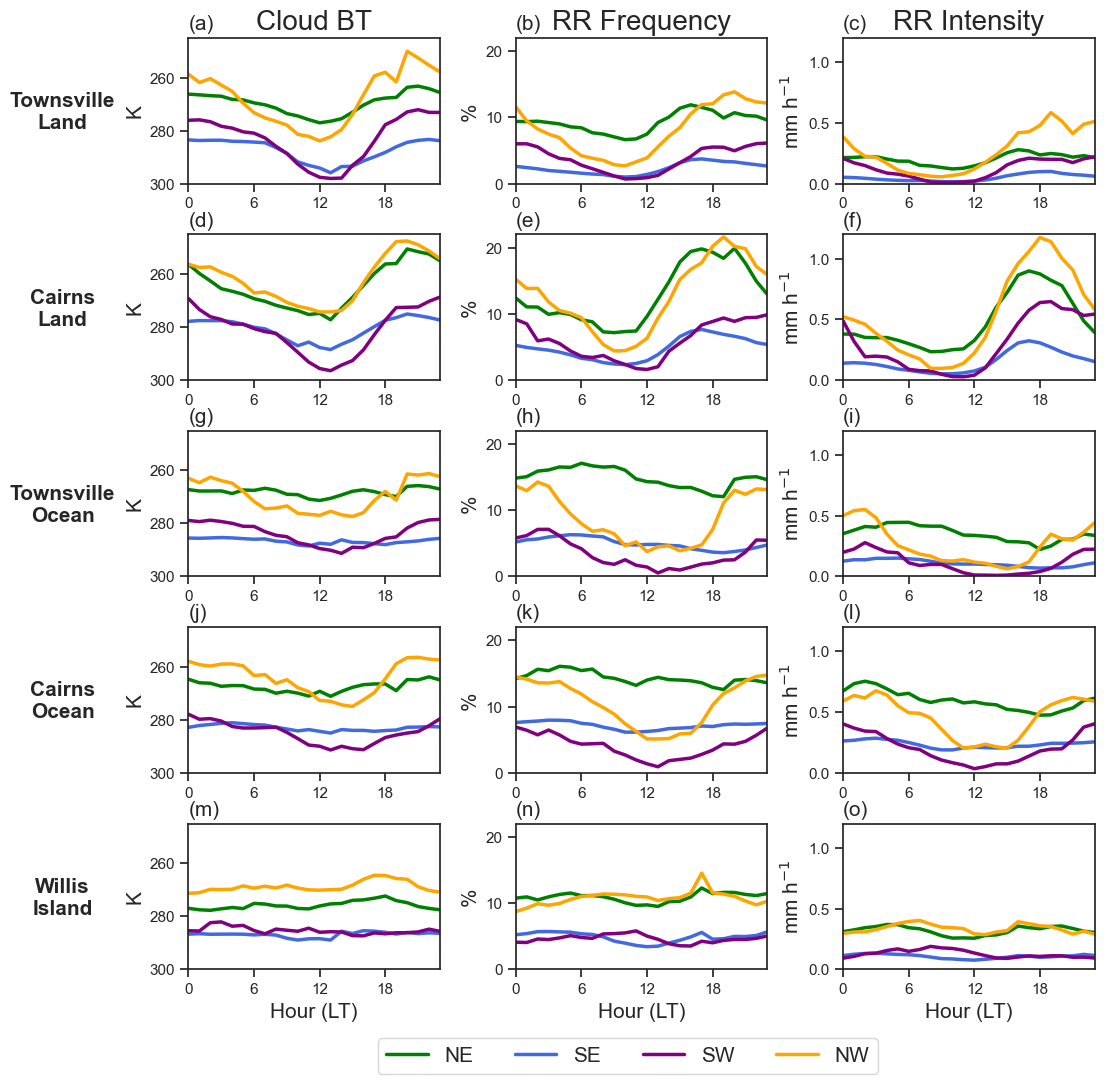

In [18]:
diurnal_cycle_plot(245, 300, 22, 1.2, data) #30,-30